In [237]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from itertools import product
import warnings
from scipy import stats
from dateutil.relativedelta import relativedelta
import datetime
%matplotlib inline

In [207]:
df = pd.read_csv('WAG_C_M.csv',sep = ';', index_col = ['month'], parse_dates=['month'], dayfirst=True)
df.head(15)

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
1993-06-01,47.4
1993-07-01,56.0
1993-08-01,65.4
1993-09-01,80.9


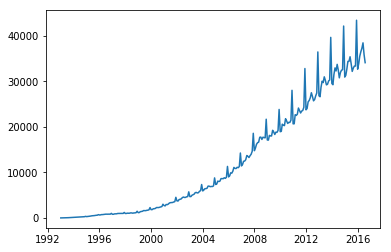

In [208]:
plt.plot(df)

In [209]:
sm.tsa.stattools.adfuller(df['WAG_C_M'])

(0.8134112642935677,
 0.9918495954854735,
 14,
 269,
 {'1%': -3.4548957220044336,
  '5%': -2.8723451788613157,
  '10%': -2.572527778361272},
 3861.7644347401174)

ряд имеет ярко-выраженный тренд и годовую сезонность, он нестационарен

In [210]:
df['old_WAG_C_M'] = np.log(df['WAG_C_M'])

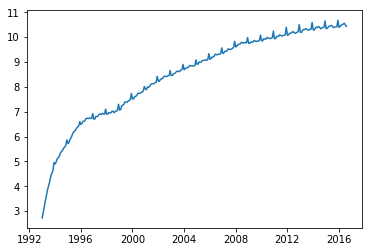

In [211]:
df['WAG_C_M'] = np.log(df['WAG_C_M'])
plt.plot(df['WAG_C_M'])

In [212]:
sm.tsa.stattools.adfuller(df['WAG_C_M'])

(-3.009569150704238,
 0.034010374116989275,
 14,
 269,
 {'1%': -3.4548957220044336,
  '5%': -2.8723451788613157,
  '10%': -2.572527778361272},
 -1217.2355475245004)

стабилизировали дисперсию с помощью логарифмирования. согласно крит. Дики-Фуллера ряд стационарен, но по графику видно что это не так, ряд также имеет тренд 

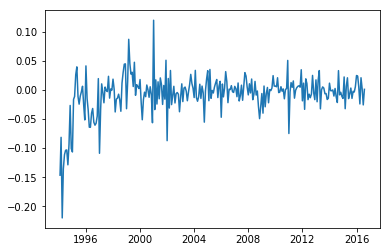

In [213]:
df['WAG_C_M'] = df['WAG_C_M'] - df['WAG_C_M'].shift(12)
df['WAG_C_M'] = df['WAG_C_M'] - df['WAG_C_M'].shift(1)
plt.plot(df['WAG_C_M'])

In [214]:
sm.tsa.stattools.adfuller(df['WAG_C_M'][13:])

(-3.407349893525098,
 0.010710851546578805,
 16,
 254,
 {'1%': -3.456360306409983,
  '5%': -2.8729872043802356,
  '10%': -2.572870232500465},
 -1200.951735659067)

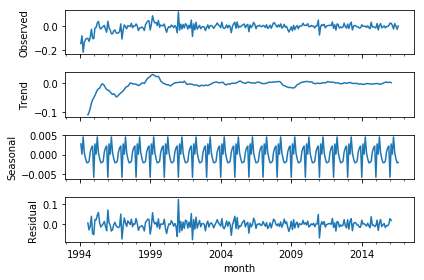

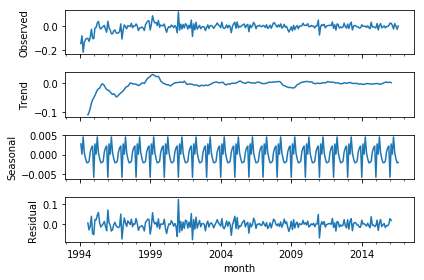

In [215]:
sm.tsa.seasonal_decompose(df['WAG_C_M'][13:]).plot()

сделали сезонное и обычное диффер. здесь уже ряд более стационарен, особенно если смотреть на последние несколько лет. тренд колеблется около константы

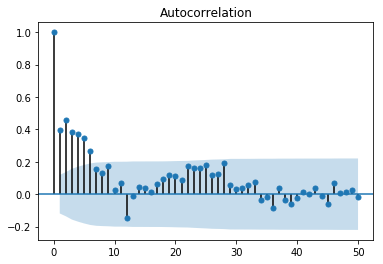

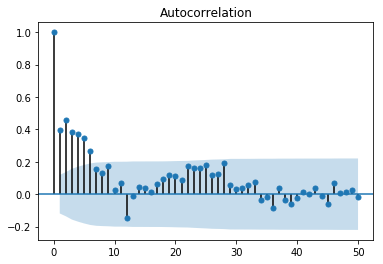

In [216]:
sm.graphics.tsa.plot_acf(df['WAG_C_M'][13:].values.squeeze(), lags=50)

сезонные значимые лаги отсутствуют => Q = 0; несезонный q = 6

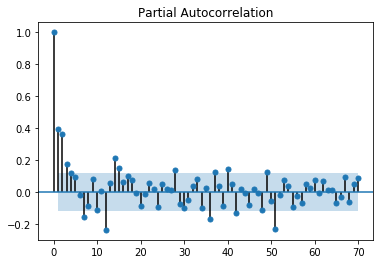

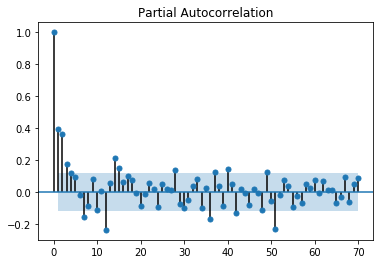

In [217]:
sm.graphics.tsa.plot_pacf(df['WAG_C_M'][13:].values.squeeze(), lags=70)

P = 1; несезонный p = 11

In [218]:
ps = range(0, 11)
d=1
qs = range(0, 7)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [219]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

154

In [220]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df['old_WAG_C_M'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (2, 3, 0, 0)
wrong parameters: (2, 3, 1, 0)
wrong parameters: (3, 3, 0, 0)
wrong parameters: (3, 3, 1, 0)
wrong parameters: (4, 3, 0, 0)
wrong parameters: (4, 3, 1, 0)
wrong parameters: (5, 3, 0, 0)
wrong parameters: (5, 3, 1, 0)
wrong parameters: (6, 3, 0, 0)
wrong parameters: (6, 3, 1, 0)
wrong parameters: (7, 3, 0, 0)
wrong parameters: (7, 3, 1, 0)
wrong parameters: (7, 4, 0, 0)
wrong parameters: (7, 4, 1, 0)
wrong parameters: (8, 3, 0, 0)
wrong parameters: (8, 3, 1, 0)
wrong parameters: (8, 4, 0, 0)
wrong parameters: (8, 4, 1, 0)
wrong parameters: (8, 5, 0, 0)
wrong parameters: (8, 5, 1, 0)
wrong parameters: (9, 4, 0, 0)
wrong parameters: (9, 4, 1, 0)
wrong parameters: (9, 5, 0, 0)
wrong parameters: (9, 5, 1, 0)
wrong parameters: (9, 6, 0, 0)
wrong parameters: (9, 6, 1, 0)
wrong parameters: (10, 4, 0, 0)
wrong parameters: (10, 4, 1, 0)
wrong parameters: (10, 5, 0, 0)
wrong parameters: (10, 5, 1, 0)
wrong parameters: (10, 6, 0, 0)
wrong parameters: (10, 6, 1, 0)
CP

In [221]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
25  (1, 5, 1, 0) -1213.757651
39  (2, 6, 1, 0) -1210.655488
23  (1, 4, 1, 0) -1210.371644
37  (2, 5, 1, 0) -1210.255565
35  (2, 4, 1, 0) -1209.839086


Критерий Стьюдента: p=0.240316
Критерий Дики-Фуллера: p=0.000000


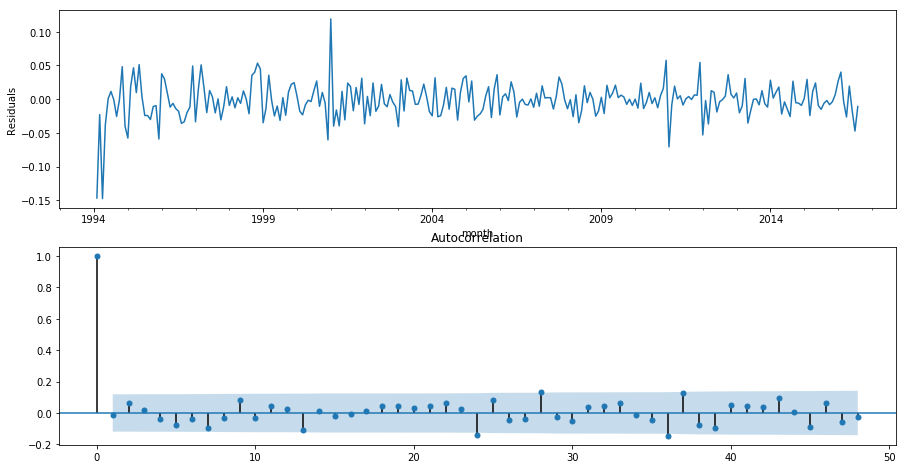

In [222]:
plt.figure(figsize = (15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

остатки не смещены и стационарны и приблизетельно неавтокоррелированы

In [223]:
df['model'] = best_model.fittedvalues
#df['model'][13:] = df['model'][13:] - np.mean(df['model'])

In [226]:
df['model'] = np.exp(df['model'])
df['old_WAG_C_M'] = np.exp(df['old_WAG_C_M'])

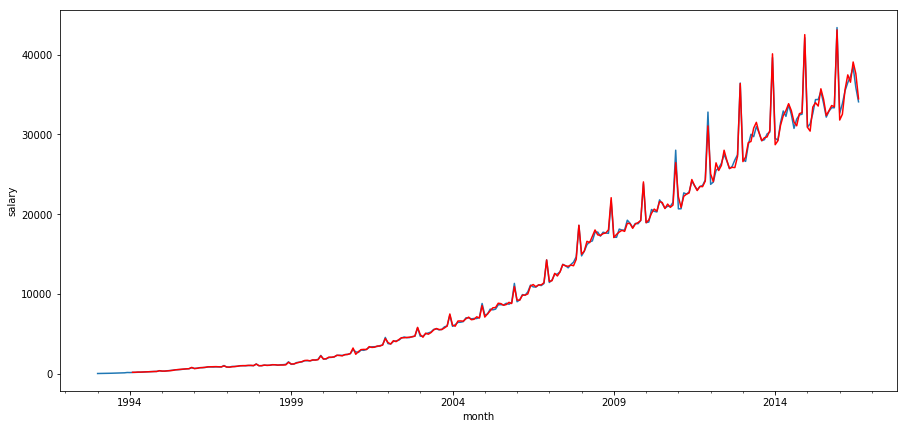

In [228]:
plt.figure(figsize = (15,7))
df['old_WAG_C_M'].plot()
df.model[13:].plot(color='r')
plt.ylabel('salary')
plt.show()

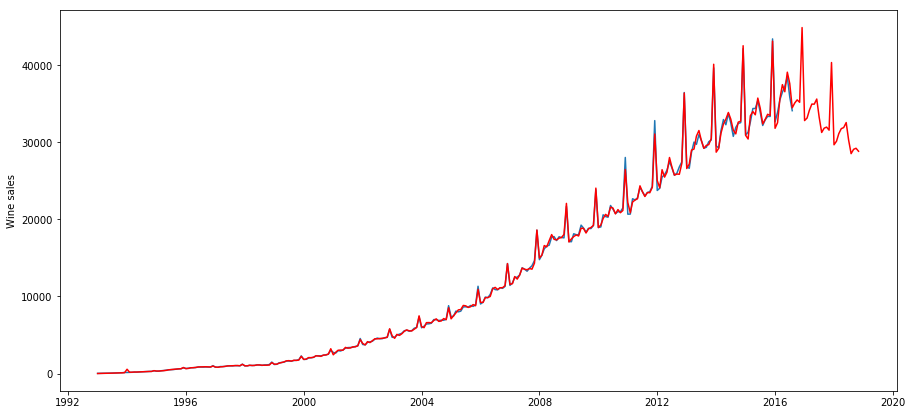

In [257]:

#date_list = [datetime.datetime.strptime("2016-07-02", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
#future = pd.DataFrame(index=date_list, columns= ['forecast'])
future = pd.DataFrame(np.exp(best_model.predict(start=0, end=310)))

plt.figure(figsize = (15,7))
plt.plot(df['old_WAG_C_M'])
plt.plot(future, color='r')
plt.ylabel('Wine sales')
plt.show()

с точки зрения математики график выглядит логично, но на деле скорее всего будет восходящий тренд